## This notebook is used for testing MTAOS communication with the AOS components: M1M3, M2, and hexapods

Step-by-step description of what we do can be found in 
Jira test case: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T???? 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rubin_jupyter_utils.lab.notebook as nb
nb.utils.get_node()

Patching auth into notebook.base.handlers.IPythonHandler(notebook.base.handlers.AuthenticatedHandler) -> IPythonHandler(jupyterhub.singleuser.mixins.HubAuthenticatedHandler, notebook.base.handlers.AuthenticatedHandler)


'andes06.cp.lsst.org'

In [3]:
from lsst.ts import salobj
import asyncio
import os

import numpy as np
from matplotlib import pyplot as plt
from astropy.time import Time
from datetime import datetime, timedelta
import pandas as pd
import yaml

from lsst.ts.observatory.control.maintel.mtcs import MTCS, MTCSUsages
from lsst.ts.observatory.control import RotType
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u

from aosTools import *

plt.jet();

Update leap second table
current_tai uses the system TAI clock


<Figure size 432x288 with 0 Axes>

In [4]:
print(os.environ["OSPL_URI"])
print(os.environ["LSST_DDS_PARTITION_PREFIX"])
print(os.environ["LSST_DDS_DOMAIN_ID"])

file:///home/hdrass/WORK/ts_ddsconfig/config/ospl-shmem.xml
summit
0


In [5]:
#index is an integter which helps avoid multple users starting same controller
script = salobj.Controller("Script", index=8)

Read historical data in 0.00 sec


In [6]:
mtcs = MTCS(script.domain)
mtcs.set_rem_loglevel(40)

In [7]:
await mtcs.start_task

Read historical data in 0.10 sec
elevation DDS read queue is full (100 elements); data may be lost
zenithAngle DDS read queue is full (100 elements); data may be lost
cameraCableWrap DDS read queue is full (100 elements); data may be lost
temperature DDS read queue is full (100 elements); data may be lost
azimuth DDS read queue is full (100 elements); data may be lost
tangentForce DDS read queue is full (100 elements); data may be lost
tangentEncoderPositions DDS read queue is full (100 elements); data may be lost
tangentActuatorSteps DDS read queue is full (100 elements); data may be lost
Read historical data in 0.20 sec
powerStatus DDS read queue is full (100 elements); data may be lost
positionIMS DDS read queue is full (100 elements); data may be lost
position DDS read queue is full (100 elements); data may be lost
netMomentsTotal DDS read queue is full (100 elements); data may be lost
netForcesTotal DDS read queue is full (100 elements); data may be lost
ilcData DDS read queue is 

[None, None, None, None, None, None, None, None, None, None]

pidData DDS read queue is full (100 elements); data may be lost
timeAndDate DDS read queue is full (100 elements); data may be lost
application DDS read queue is full (100 elements); data may be lost
motors DDS read queue is full (100 elements); data may be lost
application DDS read queue is filling: 90 of 100 elements
inclinometerData DDS read queue is full (100 elements); data may be lost
mountStatus DDS read queue is full (100 elements); data may be lost


In [8]:
#await mtcs.close() #for openSplice 6.11, the workaround was to close it then rerun the two cells above

actuators DDS read queue is full (100 elements); data may be lost
electrical DDS read queue is full (100 elements); data may be lost
actuators DDS read queue is filling: 92 of 100 elements
mountPosition DDS read queue is full (100 elements); data may be lost
imsData DDS read queue is full (100 elements); data may be lost
ccwFollowingError DDS read queue is full (100 elements); data may be lost
currentTargetStatus DDS read queue is full (100 elements); data may be lost
hardpointMonitorData DDS read queue is full (100 elements); data may be lost
hardpointActuatorData DDS read queue is full (100 elements); data may be lost
forceActuatorData DDS read queue is full (100 elements); data may be lost
accelerometerData DDS read queue is full (100 elements); data may be lost


In [9]:
mtcs.components_attr

['mtmount',
 'mtptg',
 'mtaos',
 'mtm1m3',
 'mtm2',
 'mthexapod_1',
 'mthexapod_2',
 'mtrotator',
 'mtdome',
 'mtdometrajectory']

In [10]:
camhex = mtcs.rem.mthexapod_1
m2hex = mtcs.rem.mthexapod_2
m1m3 = mtcs.rem.mtm1m3
m2 = mtcs.rem.mtm2
aos = mtcs.rem.mtaos
mount = mtcs.rem.mtmount

In [11]:
rot = mtcs.rem.mtrotator

In [12]:
def printLogMessage(data):
    print(f"{data.level}: {data.message}")
aos.evt_logMessage.callback = printLogMessage
await aos.cmd_setLogLevel.set_start(level=10, timeout=5)

In [13]:
await aos.evt_heartbeat.next(flush=True, timeout=5)

In [ ]:
await salobj.set_summary_state(m1m3, salobj.State.ENABLED, settingsToApply="Default")

In [14]:
await salobj.set_summary_state(aos, salobj.State.ENABLED) #, settingsToApply='default') #leave this out!!
#two levels of defaults: csc defaults, config repo; right now csc defaults, they will move to config repo; 
#but to load defaults from config repo, we do not need to supply settingsToApply

20: Execute configure().
10: MTAOS configuration started.
10: Using default OFC configuration directory.
10: Using default configuration directory.
10: Reading bend mode data.
10: Reading M1M3:force data.
10: Reading M1M3:rot data.
10: Reading M2:force data.
10: Reading M2:rot data.
10: Configuring comcam
10: Configuring image quality weight: /home/saluser/repos/ts_ofc/policy/comcam/imgQualWgt.yaml
10: Configuring y2: /home/saluser/repos/ts_ofc/policy/comcam/y2.yaml
10: Configuring instrisic zernikes: 7 files.
10: Configuring sensor mapping: sensorNameToFieldIdx.yaml
10: Configuring sensitivity matrix: /home/saluser/repos/ts_ofc/policy/comcam/senM_9_19_50.yaml
10: done comcam
10: ofc data ready. Creating model
10: MTAOS configuration completed.


[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [15]:
summit = 1 #use this for summit testing
#summit = 0 #use this for NCSA

In [16]:
from lsst_efd_client import EfdClient

if summit:
    client = EfdClient('summit_efd')
else:
    client = EfdClient('ncsa_teststand_efd')
csc_index = 1

#### Check summary state of each CSC

In [17]:
await checkAOSSummaryStates(aos, m1m3, m2, camhex, m2hex)

starting with: MTAOS state State.ENABLED 2021-07-20 17:16:12.212677120
starting with: M1M3 state State.ENABLED 2021-07-20 16:01:57.033743872
          detailed state DetailedState.ACTIVE 2021-07-20 16:01:57.033819136
staring with: m2 state State.ENABLED 2021-07-20 16:08:03.594931968
staring with: cam hex state State.ENABLED 2021-07-20 16:17:28.039630848
          cam hex state EnabledSubstate.STATIONARY 2021-07-20 17:10:45.388028672
staring with: M2 hex state State.ENABLED 2021-07-20 16:18:37.755570688
          hex state EnabledSubstate.STATIONARY 2021-07-20 16:25:08.711880960


### Get M1M3 Ready: raise mirorr, turn on FB, clear forces

In [ ]:
await m1m3.evt_heartbeat.next(flush=True, timeout=5)

In [ ]:
print('Re-enabling M1M3')
#await salobj.set_summary_state(m1m3, salobj.State.STANDBY) 
await salobj.set_summary_state(m1m3, salobj.State.ENABLED, settingsToApply = 'Default') #enable m1m3

In [ ]:
await readyM1M3(m1m3)

In [ ]:
#SELECT "errorCode", "errorReport" FROM "efd"."autogen"."lsst.sal.MTM1M3.logevent_errorCode" WHERE time > :dashboardTime: AND time < :upperDashboardTime:

In [ ]:
#%matplotlib inline
await plotM1M3Forces(m1m3)

### Get M2 Ready: turn on FB, clear forces

In [ ]:
await m2.evt_heartbeat.next(flush=True, timeout=5)

In [ ]:
sstate = await m2.evt_summaryState.aget(timeout=5)
print('staring with: m2 state',salobj.State(sstate.summaryState), pd.to_datetime(sstate.private_sndStamp, unit='s'))

In [ ]:
await salobj.set_summary_state(m2, salobj.State.ENABLED) 
#await salobj.set_summary_state(m1m3, salobj.State.ENABLED, settingsToApply = 'Default') #enable m1m3

In [ ]:
await m2.cmd_enterControl.set_start(timeout = 5.)

In [ ]:
await readyM2(m2)

In [ ]:
await plotM2Forces(m2)

### Get cam hex Ready: check config; make sure LUT is on, and has valid inputs; make sure hex is at LUT position

In [ ]:
await camhex.evt_heartbeat.next(flush=True, timeout=5)

In [ ]:
await salobj.set_summary_state(mount, salobj.State.ENABLED) #, settingsToApply = 'Default') 

In [ ]:
await salobj.set_summary_state(rot, salobj.State.ENABLED)

In [ ]:
await mount.cmd_moveToTarget.set_start(elevation=75, azimuth=0)

In [ ]:
await rot.cmd_move.set_start(position=0)

In [ ]:
await readyHexaForAOS(camhex)

In [ ]:
await camhex.cmd_move.set_start(x=0,y=0,z=0, u=0,v=0,w=0,sync=True)

In [ ]:
await salobj.set_summary_state(camhex, salobj.State.STANDBY)

In [ ]:
await camhex.cmd_exitControl.set_start(timeout=10.)

In [ ]:
await salobj.set_summary_state(camhex, salobj.State.ENABLED, settingsToApply="default")

In [ ]:
state = await camhex.evt_summaryState.aget(timeout=5)
print('staring with: cam hex state', salobj.State(state.summaryState), pd.to_datetime(state.private_sndStamp, unit='s'))
dstate = await camhex.evt_controllerState.aget(timeout=5)
print('          cam hex state', MTHexapod.EnabledSubstate(dstate.enabledSubstate), 
  pd.to_datetime(dstate.private_sndStamp, unit='s'))

In [ ]:
mount_angle = await mount.tel_elevation.next(flush=False, timeout=10.)
print("mount elevation angle", mount_angle.actualPosition)
elev = mount_angle.actualPosition

### Get M2 hex Ready: check config; make sure LUT is on, and has valid inputs; make sure hex is at LUT position

In [ ]:
await m2hex.evt_heartbeat.next(flush=True, timeout=5)

In [ ]:
await m2hex.cmd_setCompensationMode.set_start(enable=0, timeout=10)

In [ ]:
await m2hex.cmd_move.set_start(x=0,y=0,z=100, u=0,v=0,w=0,sync=True)

In [ ]:
await printHexaPosition(m2hex)
await printHexaUncompensatedAndCompensated(m2hex)

In [ ]:
await readyHexaForAOS(m2hex)

In [ ]:
await salobj.set_summary_state(m2hex, salobj.State.ENABLED, settingsToApply="default")

### Step 1: add aberrations via OFC

In [29]:
zernikes = np.zeros(19)
zerIdx = np.arange(4, 23)
zernikes[7-4] = -1 #add 1um of z7
print(zerIdx)
print(zernikes)

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.]


In [30]:
config = {"xref": "x0"}  # add config as needed
config_yaml = yaml.safe_dump(config)

In [28]:
await aos.cmd_addAberration.set_start(wf = zernikes, config=config_yaml)
#await aos.cmd_issueCorrection.set_start() #in the future, we want to issue corrections manually

10: Customizing OFC parameters.
10: Overriding ofc_data parameter xref.
10: Currently configured with comcam instrument.
10: Assuming white light filter to compute aberration.
10: Error setting pssn gain. Using default: 0.7.
10: Restoring ofc_data values.
10: Overriding ofc_data parameter xref.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


DOF event time =  2021-07-20 17:26:28.095399680
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


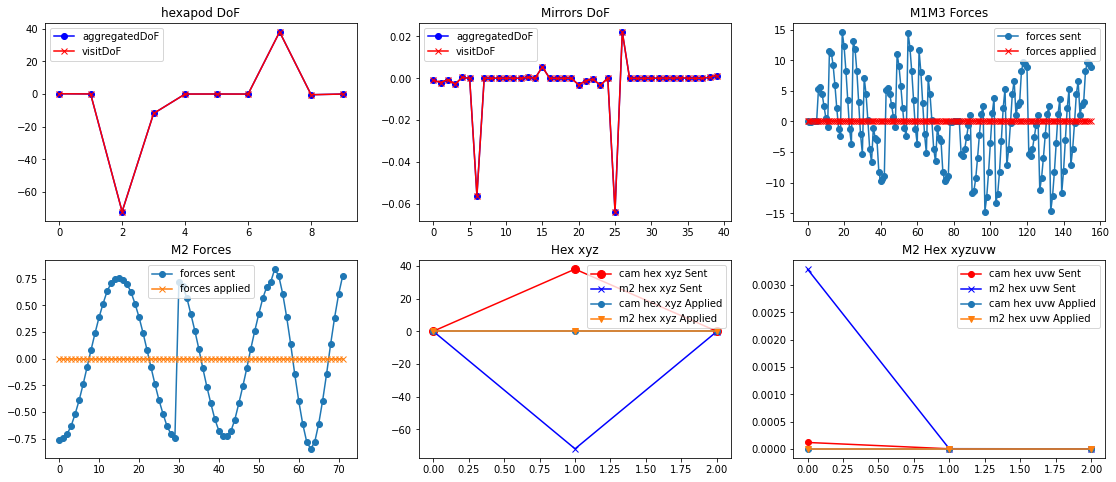

In [21]:
ofc_dict =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

In [32]:
await aos.cmd_issueCorrection.set_start() 

20: Execute do_issueCorrection().
10: Issue the M2 hexapod correction successfully.
10: Issue the camera hexapod correction successfully.
10: Issue the M2 correction successfully.
10: Issue the M1M3 correction successfully.


DOF event time =  2021-07-20 17:26:28.095399680
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


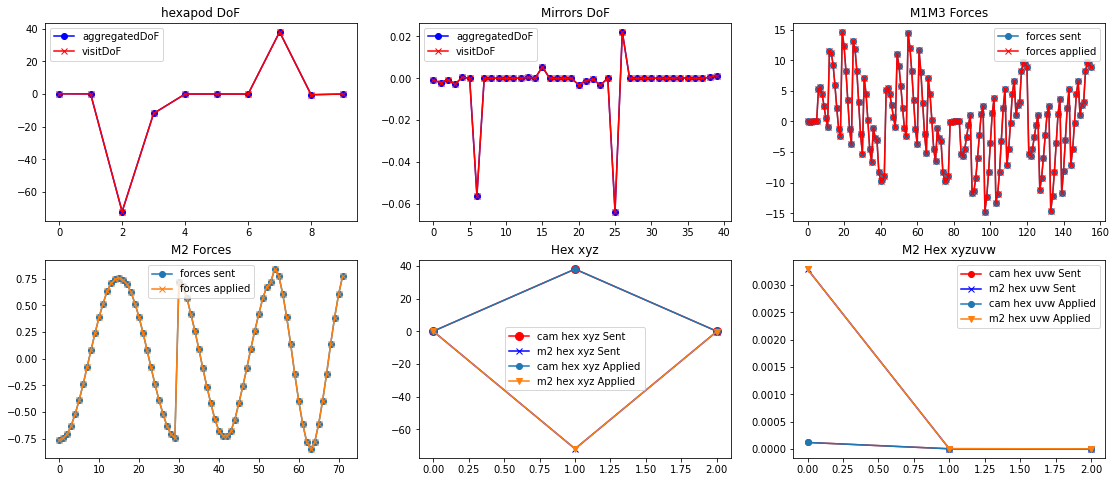

In [23]:
ofc_dict =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

In [31]:
# Disable all corrections except camera hexapod
new_comp_dof_idx = dict(
    m2HexPos=np.zeros(5, dtype=bool).tolist(),
    camHexPos=np.ones(5, dtype=bool).tolist(),
    M1M3Bend=np.zeros(20, dtype=bool).tolist(),
    M2Bend=np.zeros(20, dtype=bool).tolist(),
)
config = {"comp_dof_idx":new_comp_dof_idx}
config_yaml = yaml.safe_dump(config)
await aos.cmd_addAberration.set_start(wf = zernikes, config=config_yaml) 

10: Customizing OFC parameters.
10: Overriding ofc_data parameter comp_dof_idx.
10: Currently configured with comcam instrument.
10: Assuming white light filter to compute aberration.
10: Error setting pssn gain. Using default: 0.7.
10: Restoring ofc_data values.
10: Overriding ofc_data parameter comp_dof_idx.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


In [ ]:
config_yaml

#### Look at telemetry to verify the changes in the DOFs

In [ ]:
#end = Time(datetime.now(), scale='tai')
end = Time('2021-05-14T18:25:30', scale = 'tai')
start = end - timedelta(seconds=100)

dfm = await client.select_time_series('lsst.sal.MTMount.elevation', '*', start, end, csc_index)
dfm1m3 = await client.select_time_series('lsst.sal.MTM1M3.logevent_appliedActiveOpticForces', '*', start, end, csc_index)
dfm2 = await client.select_time_series('lsst.sal.MTM2.axialForce', '*', start, end, csc_index)
dfh = await client.select_time_series('lsst.sal.MTHexapod.logevent_uncompensatedPosition', '*', start, end, csc_index)

idx1=dfh.MTHexapodID==1
dfh1 = dfh[idx1]
idx2=dfh.MTHexapodID==2
dfh2 = dfh[idx2]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,4))
#plt.plot(dfm.actualPosition, '--', label='mount elevation')
plt.plot(dfm1m3.zForces0*1e3, label='M1M3 aos force 101 (x1000N)')
plt.plot(dfm2.applied0*1e2, label='M2 aos force B1 (x100N)')
plt.plot(dfh1.y, '*', label='Camera hexapod y (microns)')
plt.plot(dfh2.y, 'o', label='M2 hexapod y (microns)')
plt.grid()
plt.legend()

### Step 2: add same aberrations twice. Are the aggregateDOF accumulating?

In [ ]:
await aos.cmd_addAberration.set_start(wf = zernikes, config=config_yaml)

In [ ]:
await aos.cmd_issueCorrection.set_start() 

In [ ]:
ofc_dict2 = await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot=True)

This depends on the control strategy we are using. For x00, do not expect 2 or 1.

In [ ]:
ofc_dict2['camhexC'][:5]/ofc_dict['camhexC'][:5]

In [ ]:
ofc_dict2['m2hexC'][:5]/ofc_dict['m2hexC'][:5]

In [ ]:
plt.plot(ofc_dict2['aggregated_dof'][:10]/ofc_dict['aggregated_dof'][:10])

In [ ]:
plt.plot(ofc_dict2['visit_dof'][:10]/ofc_dict['visit_dof'][:10])

### Step 3: Reset the corrections

In [33]:
await aos.cmd_resetCorrection.set_start()

20: Execute do_resetCorrection().
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


In [34]:
##the following should be done by cmd_resetCorrection, but right now this is not the case
await aos.cmd_issueCorrection.set_start() 
#issue the resetted correction, which should be equivalent to the below
#await m1m3.cmd_applyActiveOpticForces.set_start(zForces=[0]*156)
#await m2.cmd_resetForceOffsets.set_start()
#await camhex.cmd_move.set_start(x=0,y=0,z=0, u=0,v=0,w=0,sync=True)
#await m2hex.cmd_move.set_start(x=0,y=0,z=0, u=0,v=0,w=0,sync=True)

20: Execute do_issueCorrection().
10: Issue the M2 hexapod correction successfully.
10: Issue the camera hexapod correction successfully.
10: Issue the M1M3 correction successfully.
10: Issue the M2 correction successfully.


DOF event time =  2021-07-20 17:45:41.968763904
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


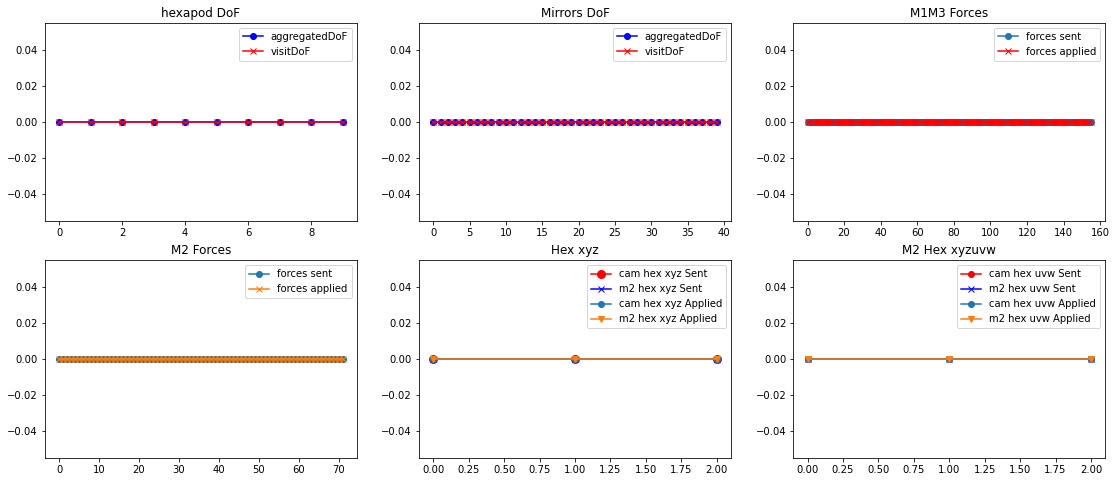

In [35]:
ofc_dict3 =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

### Step 4: Double the aberration, do the corrections double? yes

In [ ]:
zernikes[7-4] = 2 # z7 = 2um

In [ ]:
await aos.cmd_addAberration.set_start(wf = zernikes) #config=??

In [ ]:
await aos.cmd_issueCorrection.set_start() 

In [ ]:
ofc_dict4 =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

In [ ]:
ofc_dict4['camhexC'][:5]/ofc_dict['camhexC'][:5]

In [ ]:
ofc_dict4['m2hexC'][:5]/ofc_dict['m2hexC'][:5]

### Step 5: Observe the corrections being rejected

In [ ]:
#await lowerM1M3(m1m3)

In [ ]:
await salobj.set_summary_state(remote=camhex, state=salobj.State.DISABLED) 

In [ ]:
#Expect this command to be rejected, because M1M3 is parked
zernikes[7-4] = 1
await aos.cmd_addAberration.set_start(wf = zernikes) #config=??

In [ ]:
ofc_dict5 =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

In [ ]:
await aos.cmd_rejectCorrection.set_start()

In [ ]:
ofc_dict5 =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

In [ ]:
await aos.cmd_addAberration.set_start(wf = zernikes, config=config_yaml)

In [ ]:
await aos.cmd_issueCorrection.set_start()

In [ ]:
ofc_dict5 =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

In [ ]:
await aos.cmd_rejectCorrection.set_start()

In [ ]:
ofc_dict6 =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

#### the addAberration command is supposed to have undone corrections to M2, camhex, and m2hex. Let's check that

In [ ]:
print(np.array(ofc_dict5['m1m3C']) - np.array(ofc_dict4['m1m3C']))
#print(ofc_dict5['m2C'] - ofc_dict4['m2C'])
#print(ofc_dict5['camhexC'] - ofc_dict4['camhexC'])
#print(ofc_dict5['m2hexC'] - ofc_dict4['m2hexC'])

#### What about corrections on the component side?

If the sent already agrees with applied in every case above (they should), checking the sent (=corrections) here is sufficient.

### Step 6: rejectCorrection 

This makes sure OFC does proper accounting when commands are rejected.

When cmd_addAberration doesn't issue corrections, we can test cmd_rejectCorrection. NOT NOW.

In [ ]:
await aos.cmd_rejectCorrection.set_start()

In [ ]:
ofc_dict6 =  await ofcCompSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

### Close up

In [ ]:
#if we started with enabled state, we need to put it back
await salobj.set_summary_state(m1m3, salobj.State.ENABLED,  settingsToApply='Default')

In [ ]:
await salobj.set_summary_state(m2, salobj.State.OFFLINE)

In [ ]:
await salobj.set_summary_state(m1m3, salobj.State.STANDBY)

In [ ]:
await salobj.set_summary_state(camhex, salobj.State.STANDBY)

In [36]:
await salobj.set_summary_state(aos, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [ ]:
await lowerM1M3(m1m3)

### Check if the telescope is in tracking mode. If yes, need to stop stacking. 
The alternative is to check "MT Mount status" dash board on Chronograf. Make sure there are three "False".

In [ ]:
mountStatus = await mount.evt_axesInPosition.aget(timeout=5.)
rotStatus = await rot.evt_inPosition.aget(timeout=5.)
trackingStatus = mountStatus.elevation and mountStatus.azimuth and rotStatus.inPosition
print('Are we tracking?', trackingStatus)

In [ ]:
await ptg.cmd_stopTracking.set_start(timeout=5.)